In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

# Load original model

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 8min 2s
Wall time: 1min 26s
CPU times: total: 36.8 s
Wall time: 31.4 s


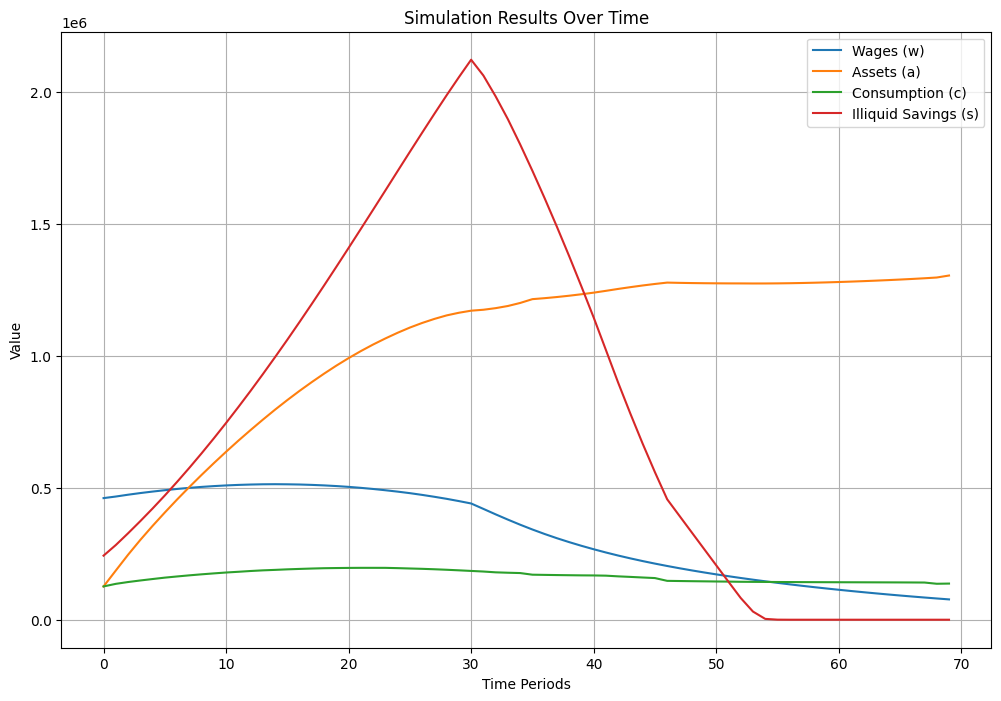

C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\2078573338.py:38: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0),
C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\2078573338.py:43: RuntimeWarning: Mean of empty slice
  "Tax rate (tax_rate)": np.nanmean(np.where(model.sim.ex == 1, model.sim.tax_rate, np.nan),axis=0),


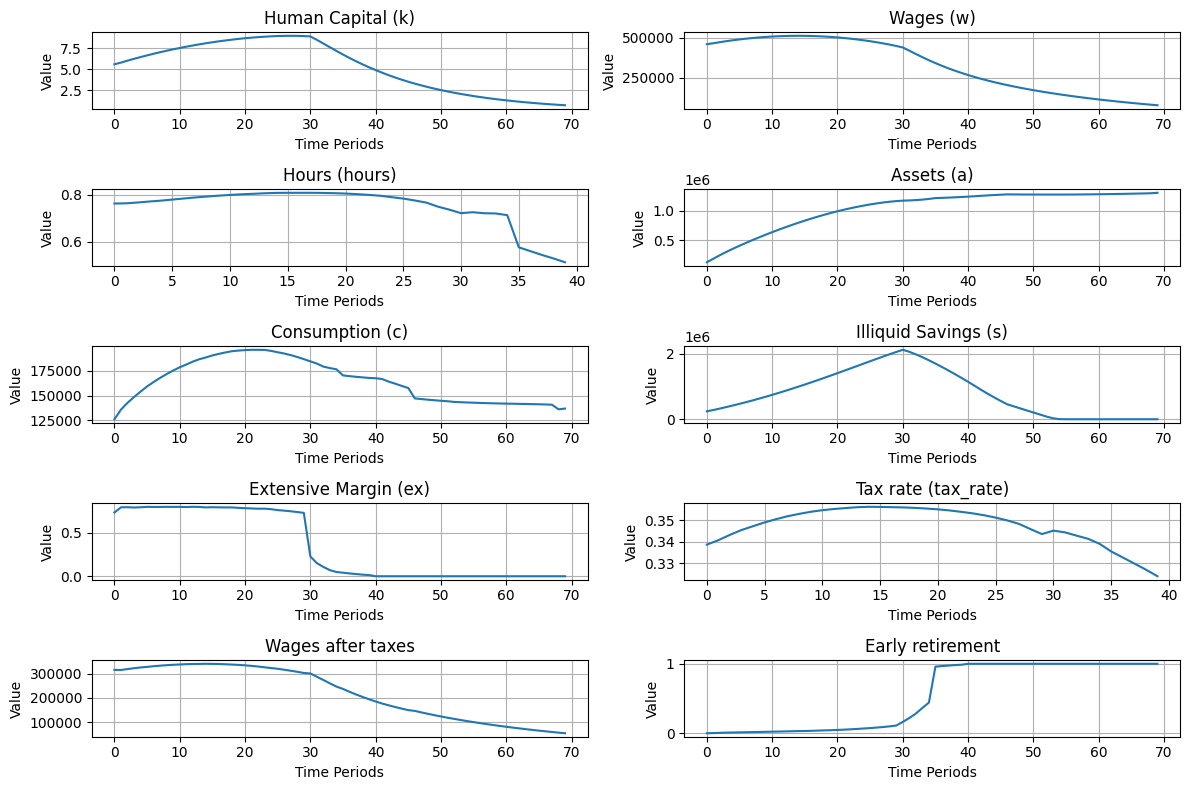

In [3]:
time = np.arange(par.T)

simulated_data = {
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
}

# Create a figure and plot each variable
plt.figure(figsize=(12, 8))
for label, data in simulated_data.items():
    plt.plot(time, data, label=label)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(12, 8))

# Titles for the plots
titles = [
    "Human Capital (k)", "Wages (w)", "Hours (hours)", 
    "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
]

# Generate example data (replace with actual values)
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": np.mean(model.sim.k[:], axis=0),
    "Wages (w)": np.mean(model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan),axis=0),
    "Assets (a)": np.mean(model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.nanmean(np.where(model.sim.ex == 1, model.sim.tax_rate, np.nan),axis=0),
    "Wages after taxes": np.mean((1-model.sim.tax_rate[:,:])*model.sim.w[:,:], axis=0),
    "Early retirement":np.sum([model.sim.e[i,:] == 2.0 for i in range(model.sim.e.shape[0])], axis=0) / model.sim.e.shape[0],
}
# Plot each variable in its respective subplot
for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
    ax.plot(time, data)
    ax.set_title(label)
    ax.set_xlabel("Time Periods")
    ax.set_ylabel("Value")
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Counter factual

In [4]:
# Change parameters and re-solve
# theta = [1.0]
# theta_names = ['alpha_f0']

theta = [36]
theta_names = ['retirement_age']

# theta = [0.03]
# theta_names = ['r_a']


og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Compare models 

Expected welfare  before parameter changes: -22.36911263412503
Expected welfare after parameter changes: -22.377410545055024
Consumption at every age before the policy change must change with -0.3 pct. to keep the same utility, and analytically: -0.3 pct.


c:\Design_retirement\WelfareMeasures.py:81: RuntimeWarning: Mean of empty slice
  sim_og_h = np.nanmean(sim_og_h_ex_1, axis=0)# age specific average
c:\Design_retirement\WelfareMeasures.py:82: RuntimeWarning: Mean of empty slice
  sim_new_h = np.nanmean(sim_new_h_ex_1, axis=0) # age specific average


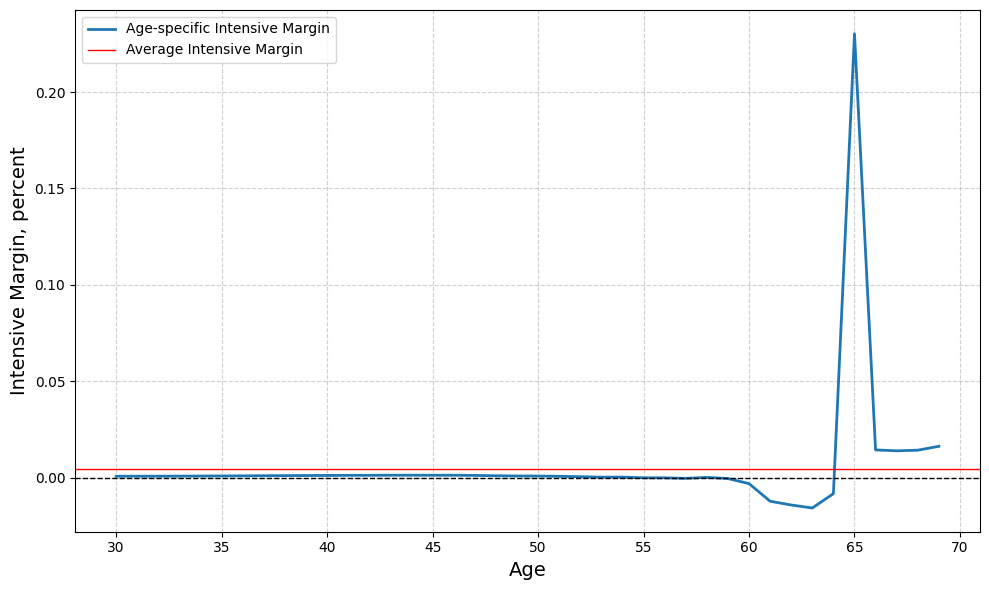

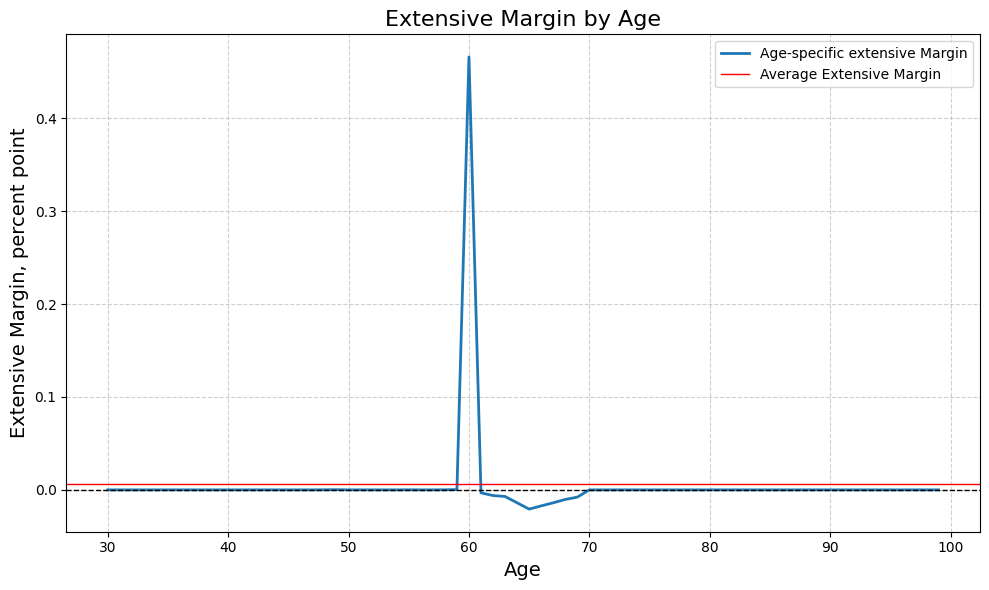

In [5]:
# Compare models 
consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, intensive_margin_age, extensive_margin_age = labor_elasticity(og_model, new_model)

# Labor supply analysis
ages = np.arange(par.start_age, par.start_age+len(intensive_margin_age))
# First plot: Intensive Margin by Age
plt.figure(figsize=(10, 6))
plt.plot(ages, intensive_margin_age, linewidth=2, label="Age-specific Intensive Margin")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(intensive_margin, color='red', linestyle='-', linewidth=1, label="Average Intensive Margin")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Intensive Margin, percent", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

# Second plot: Extensive Margin by Age
plt.figure(figsize=(10, 6))
plt.plot(ages, extensive_margin_age, linewidth=2, label="Age-specific extensive Margin")
plt.title("Extensive Margin by Age", fontsize=16)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Horizontal line at 0
plt.axhline(extensive_margin, color='red', linestyle='-', linewidth=1, label="Average Extensive Margin")
plt.xlabel("Age", fontsize=14)
plt.ylabel("Extensive Margin, percent point", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

# comparison of means

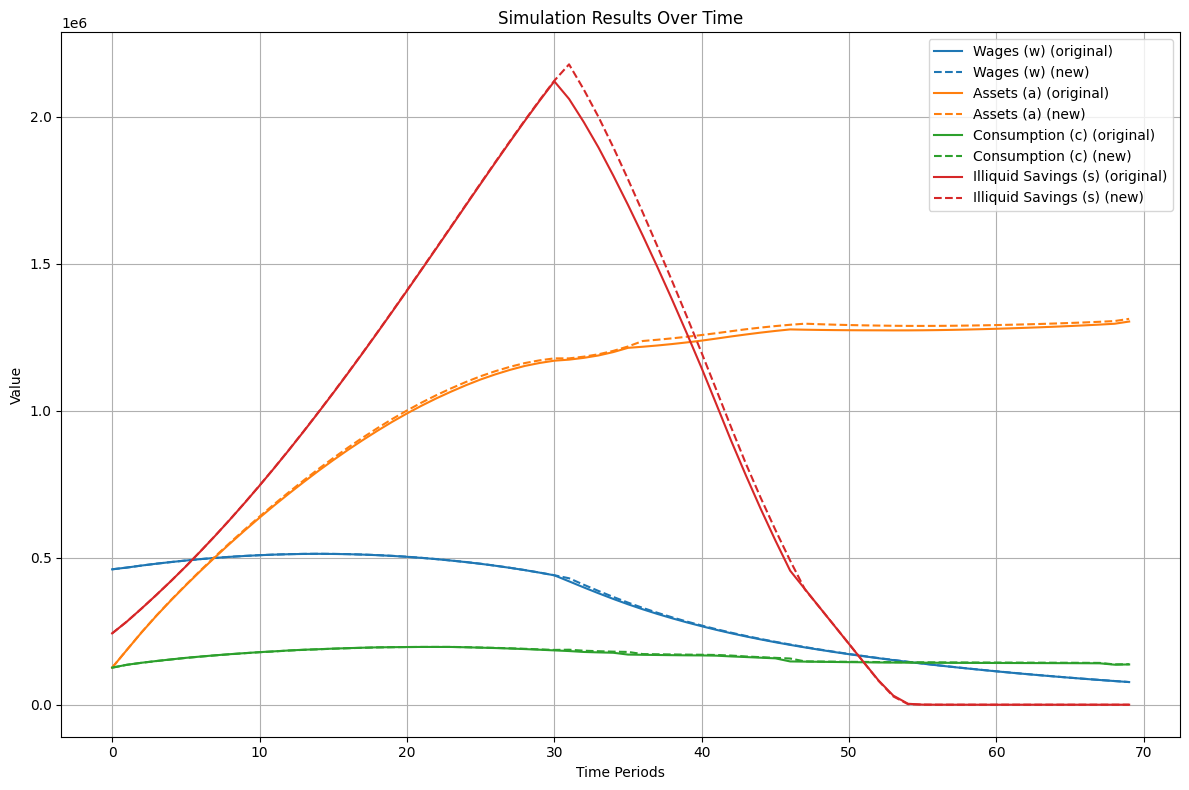

C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\3893859822.py:46: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\3893859822.py:58: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\3893859822.py:70: RuntimeWarning: Mean of empty slice
  "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0) - np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),


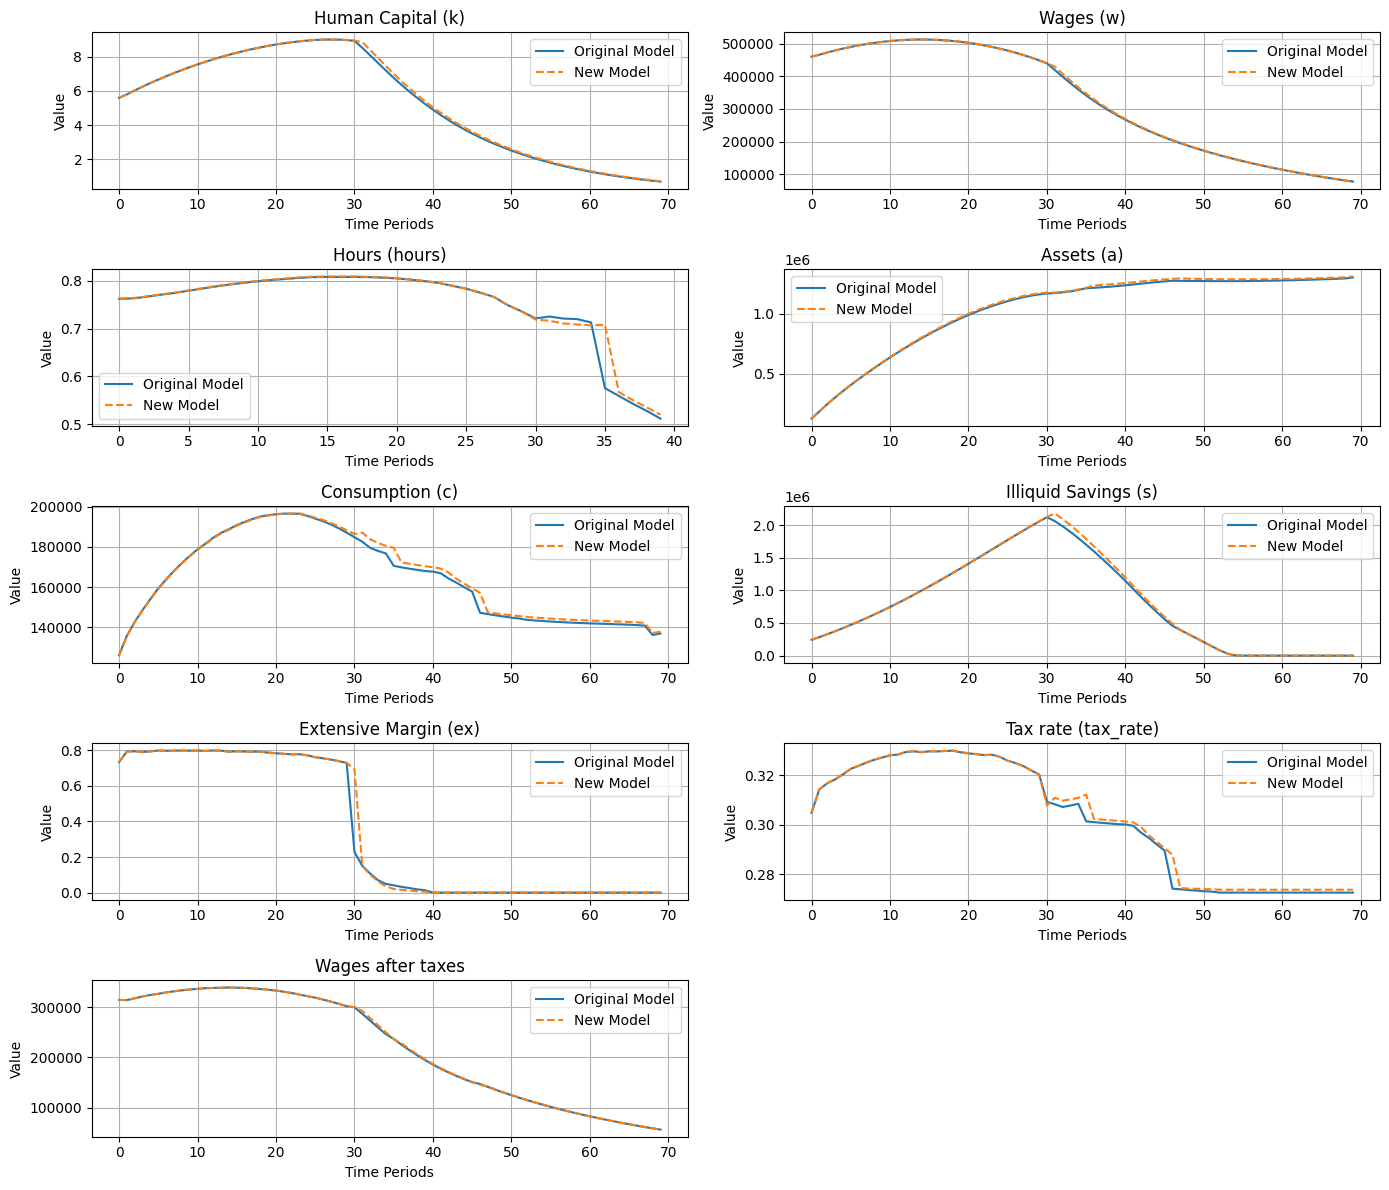

C:\Users\B224264\AppData\Local\Temp\ipykernel_27580\3893859822.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


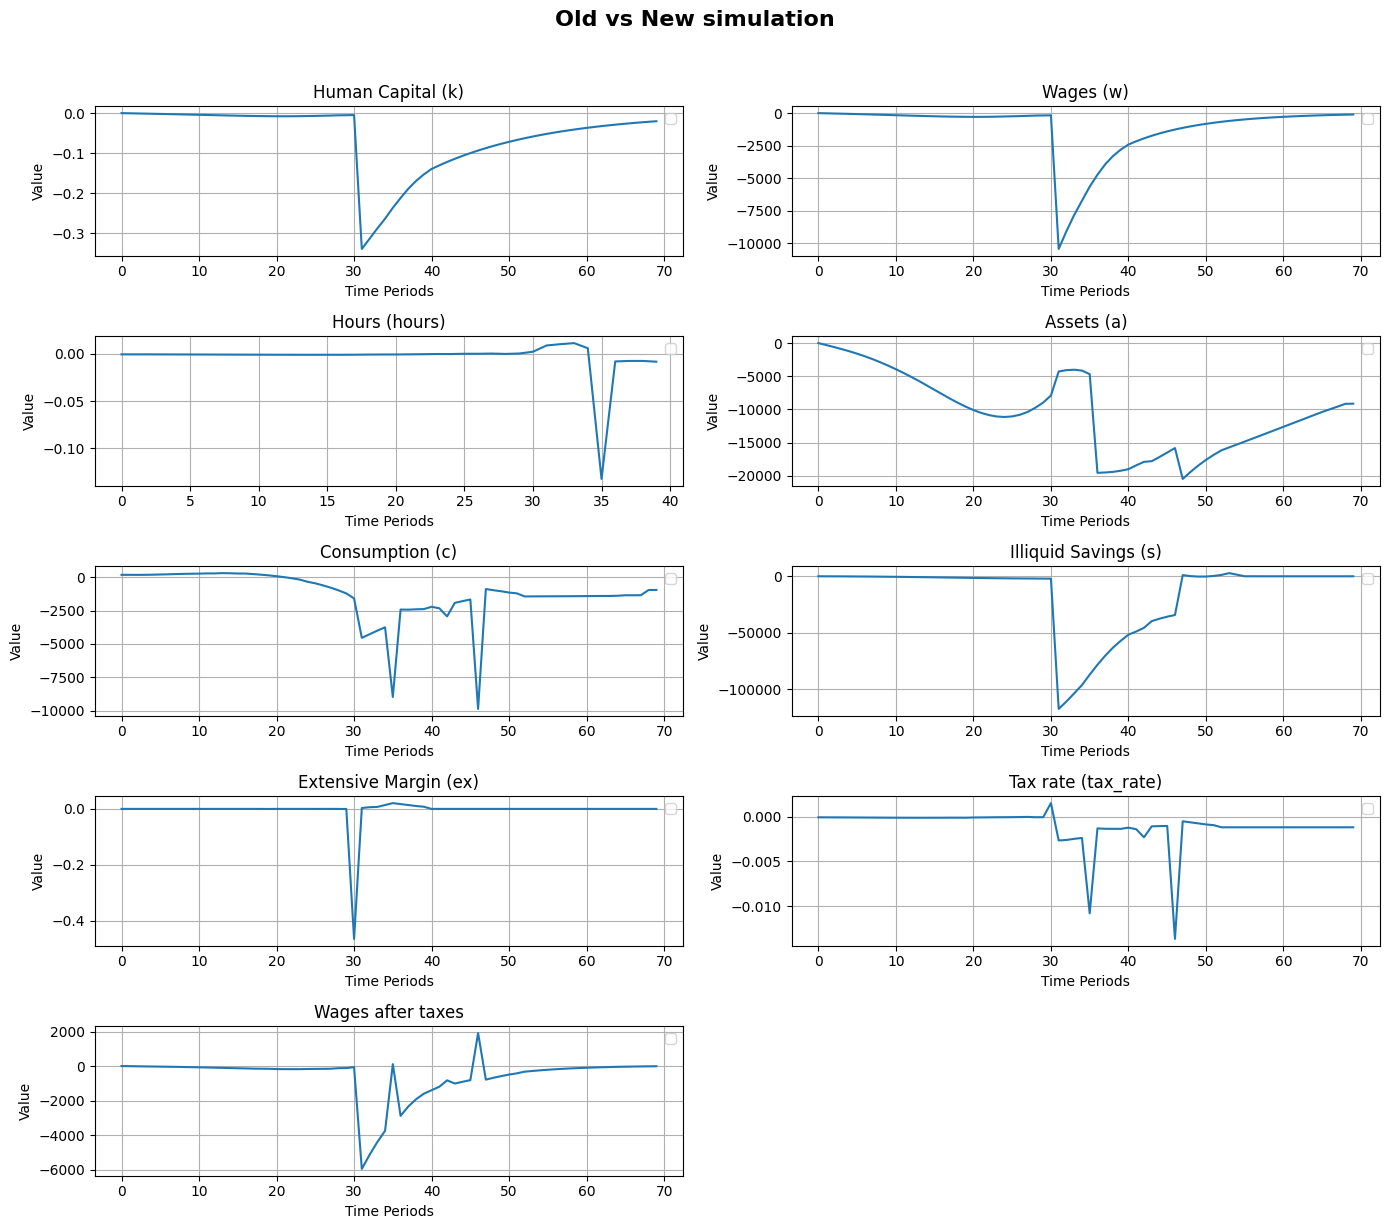

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Time array
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

# Plot summary variables with matching colors
plt.figure(figsize=(12, 8))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, label in enumerate(summary_vars):
    color = color_cycle[idx % len(color_cycle)]
    plt.plot(time, simulated_data_og[label], linestyle='-', label=f"{label} (original)", color=color)
    plt.plot(time, simulated_data_new[label], linestyle='--', label=f"{label} (new)", color=color)

# Formatting
plt.xlabel("Time Periods")
plt.ylabel("Value")
plt.title("Simulation Results Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- MULTIPLE SUBPLOTS COMPARISON -----------

# Full variable set
data_dict_new = {
    "Human Capital (k)": np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}

data_dict_og = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0),
}

data_dict_diff = {
    "Human Capital (k)": np.mean(og_model.sim.k[:], axis=0)- np.mean(new_model.sim.k[:], axis=0),
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0) -np.mean(new_model.sim.w[:], axis=0),
    "Hours (hours)": np.nanmean(np.where(og_model.sim.ex == 1, og_model.sim.h, np.nan), axis=0) - np.nanmean(np.where(new_model.sim.ex == 1, new_model.sim.h, np.nan), axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0) - np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0) - np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0) - np.mean(new_model.sim.s[:], axis=0),
    "Extensive Margin (ex)": np.mean(og_model.sim.ex[:], axis=0) - np.mean(new_model.sim.ex[:], axis=0),
    "Tax rate (tax_rate)": np.mean(og_model.sim.tax_rate[:,:], axis=0) - np.mean(new_model.sim.tax_rate[:,:], axis=0),
    "Wages after taxes": np.mean((1 - og_model.sim.tax_rate[:,:]) * og_model.sim.w[:,:], axis=0) -np.mean((1 - new_model.sim.tax_rate[:,:]) * new_model.sim.w[:,:], axis=0),
}


# Subplots setup
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()

# Plot both models with different colors per subplot
for i, (label, data_new) in enumerate(data_dict_new.items()):
    data_og = data_dict_og[label]
    axes[i].plot(time, data_og, linestyle='-', label='Original Model', color='tab:blue')
    axes[i].plot(time, data_new, linestyle='--', label='New Model', color='tab:orange')
    axes[i].set_title(label)
    axes[i].set_xlabel("Time Periods")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].legend()

# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Subplots setup
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
axes = axes.flatten()
fig.suptitle("Old vs New simulation", fontsize=16, fontweight='bold', y=1.02)

# Plot both models with different colors per subplot
for i, (label, data_diff) in enumerate(data_dict_diff.items()):
    data_og = data_dict_diff[label]
    axes[i].plot(time, data_og, linestyle='-')
    axes[i].set_title(label)
    axes[i].set_xlabel("Time Periods")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)
    axes[i].legend()

# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




# Comparison of retirement age

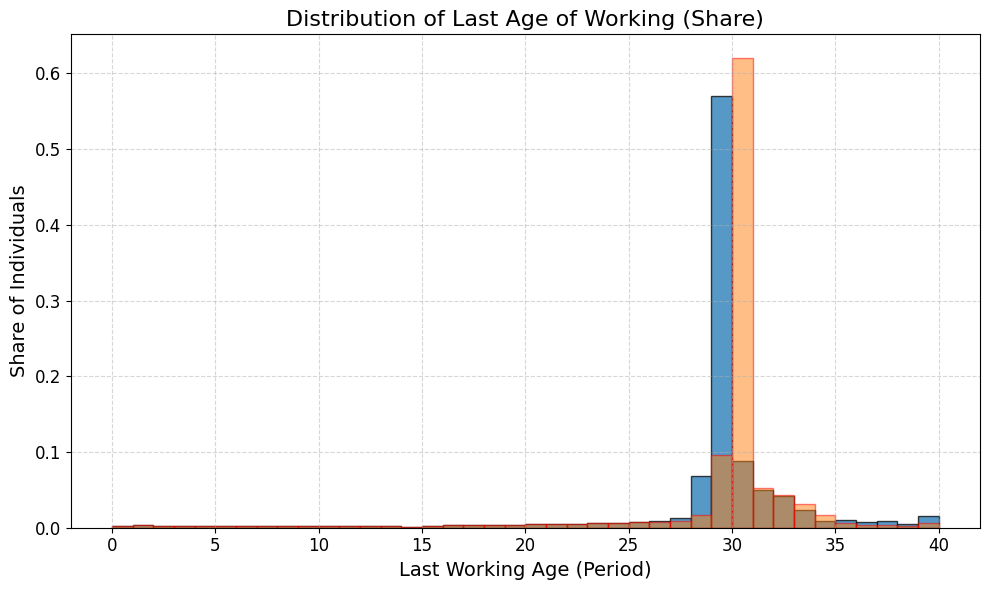

In [7]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1]  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)


# 2. Plot the histogram
plt.figure(figsize=(10, 6))

# Define bins
bins = range(int(np.nanmin(last_working)), int(np.nanmax(last_working)) + 2)
bins_new = range(int(np.nanmin(last_working_new)), int(np.nanmax(last_working_new)) + 2)

# Normalize histogram to show shares
plt.hist(last_working, bins=bins, edgecolor='black', alpha=0.75,
         weights=np.ones_like(last_working) / np.sum(~np.isnan(last_working)), label='Original Model ' )
plt.hist(last_working_new, bins=bins_new, edgecolor='red', alpha=0.5,
         weights=np.ones_like(last_working_new) / np.sum(~np.isnan(last_working_new)), label='New Model ' + str([theta_names[i] + ': ' + str(theta[i]) for i in range(len(theta))]))

# Aesthetic enhancements
plt.title("Distribution of Last Age of Working (Share)", fontsize=16)
plt.xlabel("Last Working Age (Period)", fontsize=14)
plt.ylabel("Share of Individuals", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


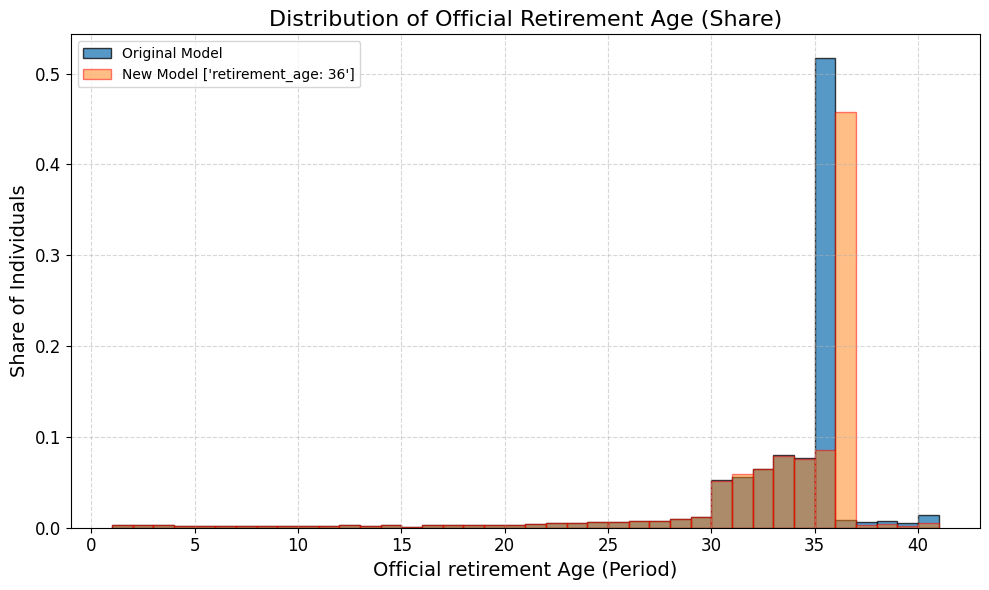

In [8]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(og_model.sim.e.shape[0], np.nan)  # initialize

for i in range(og_model.sim.e.shape[0]):
    retired = np.where(og_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire

first_retirement_new = np.full(new_model.sim.e.shape[0], np.nan)  # initialize

for i in range(new_model.sim.e.shape[0]):
    retired_new = np.where(new_model.sim.e[i, :] == 2)[0]  # find where e=2
    if retired_new.size > 0:
        first_retirement_new[i] = retired_new[0]  # first time they retire



# 2. Plot the histogram
plt.figure(figsize=(10, 6))

# Define bins
bins = range(int(np.nanmin(first_retirement)), int(np.nanmax(first_retirement)) + 2)  # +2 to include last bin
bins_new = range(int(np.nanmin(first_retirement_new)), int(np.nanmax(first_retirement_new)) + 2)  # +2 to include last bin


# Normalize histogram to show shares
plt.hist(first_retirement, bins=bins, edgecolor='black', alpha=0.75,
         weights=np.ones_like(first_retirement) / np.sum(~np.isnan(first_retirement)), label='Original Model')
plt.hist(first_retirement_new, bins=bins_new, edgecolor='red', alpha=0.5,
         weights=np.ones_like(first_retirement_new) / np.sum(~np.isnan(first_retirement_new)), label='New Model ' + str([theta_names[i] + ': ' + str(theta[i]) for i in range(len(theta))]))    


# Aesthetic stuff
plt.title("Distribution of Official Retirement Age (Share)", fontsize=16)
plt.xlabel("Official retirement Age (Period)", fontsize=14)
plt.ylabel("Share of Individuals", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


# replacement rates

In [9]:
[theta_names[i] + ': ' + str(theta[i]) for i in range(len(theta))]

['retirement_age: 36']

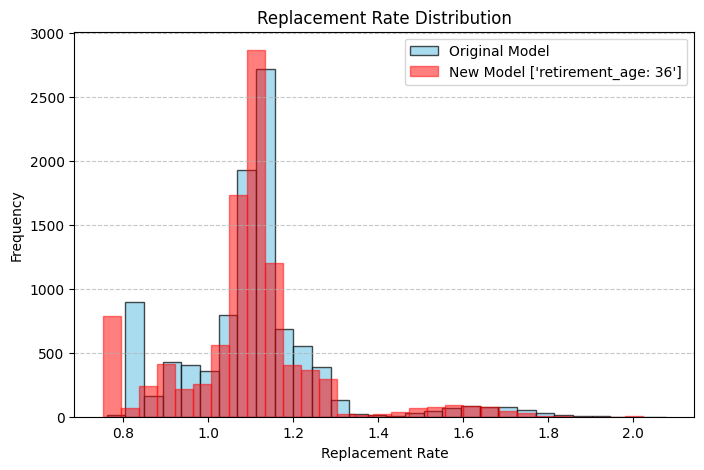

In [10]:
replacement_rate = replacement_rate_fct(og_model)
replacement_rate_new = replacement_rate_fct(new_model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(replacement_rate, bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Original Model')
plt.hist(replacement_rate_new, bins=30, color='red', edgecolor='red', alpha=0.5, label='New Model ' + str([theta_names[i] + ': ' + str(theta[i]) for i in range(len(theta))]))

# Add titles and labels
plt.title("Replacement Rate Distribution")
plt.xlabel("Replacement Rate")
plt.ylabel("Frequency")
plt.legend()  # Add a legend to differentiate between the two models
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

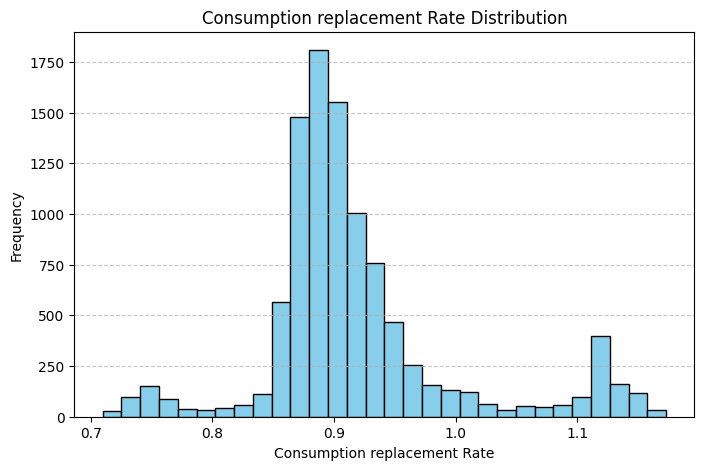

In [11]:
# calculate consumption replacement rate
consumption_replacement_rate = consumption_replacement_rate_fct(model)
# Create the histogram
plt.figure(figsize=(8, 5))  # Set the figure size
plt.hist(consumption_replacement_rate, bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title("Consumption replacement Rate Distribution")
plt.xlabel("Consumption replacement Rate")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid for better visualization

# Display the histogram
plt.show()

# Optimal retirement payments according to welfare

In [3]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([1.35e+01, 8.00e-02, 5.00e-04])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

0.0012190896453287193 [1.35e+01 8.00e-02 5.00e-04]
0.003738026373714629 [1.4175e+01 8.0000e-02 5.0000e-04]
0.0011115293059595335 [1.35e+01 8.40e-02 5.00e-04]
0.0012642209531784534 [1.35e+01 8.00e-02 5.25e-04]
0.004604881867241721 [1.39500000e+01 7.60000000e-02 5.16666667e-04]
0.004072240991448086 [1.4175e+01 7.2000e-02 5.2500e-04]
0.0035631781192144063 [1.42500000e+01 7.73333333e-02 5.27777778e-04]
0.001967335050930141 [1.47500000e+01 7.55555556e-02 5.04629630e-04]
0.003001732288447622 [1.44375000e+01 7.66666667e-02 5.09722222e-04]
0.0049314215535810136 [1.38125000e+01 7.88888889e-02 5.19907407e-04]
0.001264223775076656 [1.35e+01 8.00e-02 5.25e-04]
0.0009016619611315828 [1.37083333e+01 7.92592593e-02 4.96604938e-04]
0.003999342488553971 [1.41145833e+01 7.78148148e-02 5.19984568e-04]
0.0008845866949017103 [1.37430556e+01 7.51358025e-02 5.37705761e-04]
0.004112453240378791 [1.40670139e+01 7.87839506e-02 5.09426440e-04]
0.0008018770466887206 [1.37717593e+01 7.79670782e-02 5.10682442e-04]


# Optimal retirement payments according to welfare conditioning on pension being the same

In [ ]:
def objective_func(tau_values, model):
    time = np.arange(par.T)

    constant, beta1, beta2 = tau_values

    tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

    theta = [tau]
    theta_names = ['tau']

    og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

    consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= False, the_method = 'brentq')

    if np.mean(og_model.sim.s[:, 35]) > np.mean(new_model.sim.s[:, 35]):
        consumption_eq = -9999.9

    print(consumption_eq, tau_values)
    return -consumption_eq

tau_values_init = np.array([ 2.0, 0.4,  0.001])

bounds  = [(0,  30), 
           (-0.5,  0.5), 
           (-0.005,  0.005)]

res = minimize(objective_func, tau_values_init, args=(model, ),  
               method='Nelder-Mead', 
               bounds=bounds,
               options={'maxiter': 500})

print(res.x)

C:\Users\Peter\AppData\Local\Temp\ipykernel_21152\2827996274.py:27: OptimizeWarning: Unknown solver options: ftol
  res = minimize(objective_func, tau_values_init, args=(model, ),


0.0012190867834967133 [1.35e+01 8.00e-02 5.00e-04]
0.0037380321399434753 [1.4175e+01 8.0000e-02 5.0000e-04]
0.0011115401275957515 [1.35e+01 8.40e-02 5.00e-04]
0.0012642368453880096 [1.35e+01 8.00e-02 5.25e-04]
0.004604888707163057 [1.39500000e+01 7.60000000e-02 5.16666667e-04]
0.004072266316196301 [1.4175e+01 7.2000e-02 5.2500e-04]
0.003563207536974425 [1.42500000e+01 7.73333333e-02 5.27777778e-04]
0.001967363158467479 [1.47500000e+01 7.55555556e-02 5.04629630e-04]
0.0030017428060914665 [1.44375000e+01 7.66666667e-02 5.09722222e-04]
0.004931468857188126 [1.38125000e+01 7.88888889e-02 5.19907407e-04]
0.001264235519551172 [1.35e+01 8.00e-02 5.25e-04]
0.0009016475985062484 [1.37083333e+01 7.92592593e-02 4.96604938e-04]
0.003999347907342668 [1.41145833e+01 7.78148148e-02 5.19984568e-04]
0.0008845951549868115 [1.37430556e+01 7.51358025e-02 5.37705761e-04]
0.004112500936734086 [1.40670139e+01 7.87839506e-02 5.09426440e-04]
0.0008018785077696224 [1.37717593e+01 7.79670782e-02 5.10682442e-04]


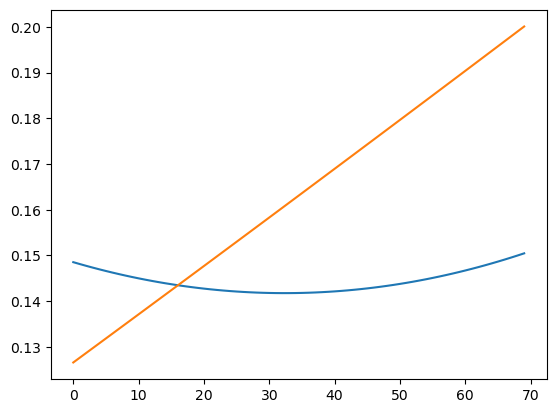

In [4]:
# constant, beta1, beta2 = np.array([ 1.46922503e+01, -2.31206543e-02,  6.27520107e-04]) # Current optimal giving 0.0065521344388923845 consumption eq.
constant, beta1, beta2 = np.array([ 1.48536631e+01, -4.18610966e-02,  6.47243901e-04]) # Test start


time = np.arange(par.T)

tau = np.maximum((constant + beta1*time + beta2*time**2) / 100, 0)

plt.plot(tau)
plt.plot(par.tau)
plt.show()


In [ ]:
theta = [tau]
theta_names = ['tau']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)

In [ ]:
a_dict = {
    'hours': [np.nanmean(np.where(model.sim.ex == 1, model.sim.h, np.nan), axis=0)[:40],
              moments['hours']],
    'extensive': [np.mean(model.sim.ex, axis=0)[:40],
                  moments['extensive']],
    'illiquid': [np.clip(np.mean(model.sim.s, axis=0), 0, None),
                 moments['savings']],
    'liquid': [np.mean(model.sim.a, axis=0),
               moments['assets']]
}

# set up 2x2 axes
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, (key, (sim, emp)) in zip(axes, a_dict.items()):
    x_vals = np.arange(len(emp)) + par.start_age

    # real data: solid grey
    ax.plot(x_vals, emp,
            color='grey',
            linestyle='-',
            linewidth=2,
            label=f"Real {key.capitalize()}")

    # simulated data: darker dashed
    ax.plot(x_vals, sim,
            color='black',
            linestyle='--',
            linewidth=2,
            label=f"Simulated {key.capitalize()}")

    ax.set_xlabel("Age")
    ax.set_ylabel(key.capitalize())
    ax.set_title(key.capitalize())
    ax.grid(True)
    ax.legend()

fig.tight_layout()
plt.show()
